In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
from omegaconf import OmegaConf
from diffusers import DDIMScheduler
from torchvision import transforms as pth_transforms
from tqdm.auto import tqdm

from janus.models import MultiModalityCausalLM, VLChatProcessor
from util.query_janus_util import equip_janus


exp_path = "/data1/jjc/experiment/bi_tok/0607_query_janus"

config = OmegaConf.load(os.path.join(exp_path, "config.yaml"))

janus = MultiModalityCausalLM.from_pretrained("/data1/ckpts/deepseek-ai_/Janus-Pro-1B", trust_remote_code=True)
janus, train_scheduler = equip_janus(janus, config)

vl_chat_processor = VLChatProcessor.from_pretrained("/data1/ckpts/deepseek-ai_/Janus-Pro-1B")
tokenizer = vl_chat_processor.tokenizer

diff_ckpt = torch.load(os.path.join(exp_path, "dit-bi_tok-100000"), map_location="cpu")
janus.dit.load_state_dict(diff_ckpt, strict=True)

query_ckpt = torch.load(os.path.join(exp_path, "query-bi_tok-100000"), map_location="cpu")
janus.query.data.copy_(query_ckpt["query"]);

sample_scheduler = DDIMScheduler(
    beta_schedule          = "scaled_linear",
    beta_start             = 0.00085,
    beta_end               = 0.012,
    num_train_timesteps    = 1000,
    clip_sample            = False,
    prediction_type        = "v_prediction",
    set_alpha_to_one       = True,
    steps_offset           = 1,
    trained_betas          = None,
    timestep_spacing       = "trailing",
    rescale_betas_zero_snr = True
)
inversed_transform = pth_transforms.Compose([
    pth_transforms.ToPILImage(),
])


def diff_generate(z, dit):
    sample_scheduler.set_timesteps(50)
    B = z.shape[0]

    pred_latents = torch.randn((B, 576, 1024), device=z.device, dtype=z.dtype)
    pred_latents *= sample_scheduler.init_noise_sigma

    for t in tqdm(sample_scheduler.timesteps):
        pred_latents = sample_scheduler.scale_model_input(pred_latents, t)
        with torch.no_grad():
            t_sample = torch.as_tensor([t], device=z.device)
            noise_pred = dit(pred_latents, z, t_sample.repeat(B))
            pred_latents = sample_scheduler.step(noise_pred, t, pred_latents).prev_sample
    
    return pred_latents

device = torch.device("cuda:7")
dtype = torch.float32

janus = janus.to(device, dtype).eval();

from model.decoder import get_decoder

config = OmegaConf.load("config/janus_gen.yaml")
decoder = get_decoder(config.decoder)
ckpt = torch.load("/data1/jjc/experiment/bi_tok/0527_janus_decoder_1024_journeydb/Decoder-bi_tok-80k", map_location="cpu")
decoder.load_state_dict(ckpt, strict=True)

decoder = decoder.to(device, dtype).eval();

/home/jjc/miniconda3/envs/dllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


/home/jjc/miniconda3/envs/dllm/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:604: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


[2025-06-10 09:09:28,730] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/jjc/miniconda3/envs/dllm/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/jjc/miniconda3/envs/dllm/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why t

In [21]:
prompt = "A red dog in a desert"

B = 1
cfg_scale = 3

input_ids = vl_chat_processor.tokenizer.encode(prompt)
input_ids = torch.LongTensor(input_ids)
input_ids = torch.cat([input_ids, torch.tensor([100003])]).to(device).unsqueeze(0)


if cfg_scale > 1:
    input_ids = input_ids.repeat(2, 1)
    input_ids[1, :-1] = 100002
    text_embedding = janus.language_model.get_input_embeddings()(input_ids).to(device)
    joint_embedding = torch.cat((text_embedding, janus.query.unsqueeze(0).repeat(2, 1, 1)), dim=1)
else:
    text_embedding = janus.language_model.get_input_embeddings()(input_ids).to(device)
    joint_embedding = torch.cat((text_embedding, janus.query.unsqueeze(0)), dim=1)



with torch.no_grad():
    hidden_states = janus.language_model(
        inputs_embeds        = joint_embedding,
        attention_mask       = None,
        output_hidden_states = True,
    ).hidden_states[-1]
    z = hidden_states[:, -576:, :]
    # z = janus.connector(z)
    print(z.shape)

    if cfg_scale > 1:
        z_cond = z[0]
        z_uncond = z[1]
        z = z_uncond + cfg_scale * (z_cond - z_uncond)
        z = z.unsqueeze(0)
    else:
        z = z

print(z.shape)


torch.Size([2, 576, 2048])
torch.Size([1, 576, 2048])


In [22]:
gen = diff_generate(z, janus.dit)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 49.53it/s]


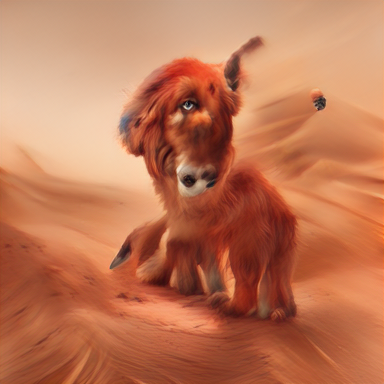

In [23]:
gen = decoder(gen)
gen = ((gen + 1) / 2).clamp(0, 1)
gen = inversed_transform(gen.squeeze(0))

gen